# Federated Learning Vulnerabilities

Federated learning is a process whereby different organizations, or devices, or groups, train models locally on their 'federated' data, and submit the gradients to a global model. This process in theory preserves the privacy of users or data samples. 

Imagine a population health and economic model to give insights into behaviour, spending, financial status and health. Obviously these are all areas where identifiable data is extremely sensitive, so federated learning would be key. 

Here is a diagram to show the flow:

<img src="images/federated_learning.png" width="600">

In the imaginery scenario for this notebook, we will focus on a health model. We will use synthetic medical data again from three hospitals that have decided to collaborate on a heart disease prediction model.


In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import pandas as pd
from typing import List, Tuple
import warnings
warnings.filterwarnings('ignore')

In [5]:
def create_medical_dataset(n_patients=300):
    """Creates a synthetic medical dataset"""
    np.random.seed(42)
    
    # Generate correlated medical features
    ages = np.random.normal(55, 15, n_patients).clip(20, 90)
    
    # Cholesterol tends to increase with age, with some noise
    cholesterol = 150 + 2 * ages + np.random.normal(0, 30, n_patients)
    cholesterol = cholesterol.clip(120, 350)
    
    # Blood pressure correlated with age and cholesterol
    systolic_bp = 90 + 0.8 * ages + 0.1 * cholesterol + np.random.normal(0, 15, n_patients)
    systolic_bp = systolic_bp.clip(90, 200)
    
    # Heart rate - younger people tend to have higher resting rates
    heart_rate = 85 - 0.2 * ages + np.random.normal(0, 10, n_patients)
    heart_rate = heart_rate.clip(50, 120)
    
    # Exercise hours per week - tends to decrease with age
    exercise_hours = np.maximum(0, 8 - 0.05 * ages + np.random.normal(0, 3, n_patients))
    
    # BMI - some correlation with age and exercise
    bmi = 22 + 0.1 * ages - 0.3 * exercise_hours + np.random.normal(0, 4, n_patients)
    bmi = bmi.clip(16, 45)
    
    # Create feature matrix
    X = np.column_stack([ages, cholesterol, systolic_bp, heart_rate, exercise_hours, bmi])
    
    # Create heart disease labels based on realistic risk factors
    risk_score = (
        0.03 * ages + 
        0.01 * cholesterol + 
        0.02 * systolic_bp + 
        -0.05 * exercise_hours + 
        0.1 * bmi + 
        np.random.normal(0, 2, n_patients)
    )
    
    # Convert to binary classification (heart disease or not)
    y = (risk_score > np.percentile(risk_score, 70)).astype(int)  # 30% have heart disease
    
    feature_names = ['Age', 'Cholesterol', 'Systolic_BP', 'Heart_Rate', 'Exercise_Hours', 'BMI']
    
    return X, y, feature_names

In [20]:
def create_hospital_data():
    """Create data for three different hospitals with realistic differences"""
    X, y, feature_names = create_medical_dataset()
    
    # Hospital A: Urban hospital, younger population, more health-conscious
    hospital_a_indices = np.where((X[:, 0] < 50) | (X[:, 4] > 5))[0][:80]  # Younger or more active
    
    # Hospital B: Suburban hospital, middle-aged population
    hospital_b_indices = np.where((X[:, 0] >= 40) & (X[:, 0] <= 65))[0][:90]
    
    # Hospital C: Rural hospital, older population, less access to preventive care
    hospital_c_indices = np.where((X[:, 0] > 55) | (X[:, 2] > 140))[0][:80]  # Older or higher BP
    
    # Ensure no overlap
    used_indices = set()
    hospitals_data = []
    hospital_names = ["Edinburgh Hospital", "Clydebank Hospital", "Orkney Hospital"]
    
    for i, indices in enumerate([hospital_a_indices, hospital_b_indices, hospital_c_indices]):
        available_indices = [idx for idx in indices if idx not in used_indices][:70 + i*10]
        used_indices.update(available_indices)
        
        hospital_X = X[available_indices]
        hospital_y = y[available_indices]
        
        hospitals_data.append((hospital_X, hospital_y, hospital_names[i]))
    
    return hospitals_data, feature_names

In [21]:
# Create hospital datasets
hospitals_data, feature_names = create_hospital_data()

print(f"\nCreated data for {len(hospitals_data)} hospitals:")
for i, (hosp_X, hosp_y, name) in enumerate(hospitals_data):
    heart_disease_rate = np.mean(hosp_y) * 100
    avg_age = np.mean(hosp_X[:, 0])
    print(f"{name}:")
    print(f"  • {len(hosp_X)} patients")
    print(f"  • Heart disease rate: {heart_disease_rate:.1f}%")
    print(f"  • Average age: {avg_age:.1f} years")
    print(f"  • Avg cholesterol: {np.mean(hosp_X[:, 1]):.0f} mg/dL")


Created data for 3 hospitals:
Edinburgh Hospital:
  • 70 patients
  • Heart disease rate: 17.1%
  • Average age: 49.2 years
  • Avg cholesterol: 253 mg/dL
Clydebank Hospital:
  • 44 patients
  • Heart disease rate: 34.1%
  • Average age: 54.3 years
  • Avg cholesterol: 260 mg/dL
Orkney Hospital:
  • 13 patients
  • Heart disease rate: 53.8%
  • Average age: 72.3 years
  • Avg cholesterol: 289 mg/dL


### Federated learning set up 

In [22]:
class HospitalClient:
    """Represents a hospital participating in federated learning"""
    
    def __init__(self, patient_data_x, patient_data_y, hospital_name):
        self.hospital_name = hospital_name
        self.patient_data_x = torch.FloatTensor(patient_data_x)
        self.patient_data_y = torch.LongTensor(patient_data_y)
        self.model = None
    
    def set_model(self, model):
        self.model = model
    
    def train_on_patients(self, epochs=1, lr=0.01):
        """Train model on hospital's patients and return gradients"""
        optimizer = optim.SGD(self.model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()
        
        initial_params = [p.clone().detach() for p in self.model.parameters()]
        
        self.model.train()
        for epoch in range(epochs):
            optimizer.zero_grad()
            predictions = self.model(self.patient_data_x)
            loss = criterion(predictions, self.patient_data_y)
            loss.backward()
            optimizer.step()
        
        # Calculate gradients
        gradients = []
        for initial, current in zip(initial_params, self.model.parameters()):
            gradients.append(current.detach() - initial)
        
        return gradients, loss.item()

In [23]:
class MedicalFLServer:
    """Federated learning server for medical collaboration"""
    
    def __init__(self, model_template):
        self.global_model = model_template
        self.hospitals = []
    
    def add_hospital(self, hospital):
        self.hospitals.append(hospital)
        hospital.set_model(self.global_model)
    
    def collaboration_round(self):
        """One round of inter-hospital collaboration"""
        all_gradients = []
        
        print("\nHospitals training locally and sharing gradients...")
        for hospital in self.hospitals:
            gradients, loss = hospital.train_on_patients()
            all_gradients.append(gradients)
            print(f"{hospital.hospital_name}: Training loss = {loss:.4f}")
        
        # Average gradients (FedAvg)
        avg_gradients = []
        for layer_idx in range(len(all_gradients[0])):
            layer_grads = torch.stack([grads[layer_idx] for grads in all_gradients])
            avg_gradients.append(torch.mean(layer_grads, dim=0))
        
        # Update global model
        for param, avg_grad in zip(self.global_model.parameters(), avg_gradients):
            param.data += avg_grad
        
        # Send updated model back to hospitals
        for hospital in self.hospitals:
            hospital.set_model(self.global_model)
        
        return all_gradients

In [24]:
# Medical prediction model
class HeartDiseasePredictor(nn.Module):
    def __init__(self, n_features=6):
        super(HeartDiseasePredictor, self).__init__()
        self.fc1 = nn.Linear(n_features, 10)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(10, 2)  # No heart disease, Heart disease
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [25]:
# Standardize medical data
scaler = StandardScaler()
all_data = np.vstack([data[0] for data in hospitals_data])
scaler.fit(all_data)

# Set up federated learning
model = HeartDiseasePredictor(n_features=len(feature_names))
fl_server = MedicalFLServer(model)

hospitals = []
for hosp_X, hosp_y, name in hospitals_data:
    standardized_X = scaler.transform(hosp_X)
    hospital = HospitalClient(standardized_X, hosp_y, name)
    hospitals.append(hospital)
    fl_server.add_hospital(hospital)


### What can we learn from the gradients?

In gradient analysis attacks, attackers learn purely from gradient statistics. Gradients are shared as part of federated learning, and a global model used for all contributed data will be accessible to at least some members of participating institutions. Each institution will use the model on their own training data, sending the gradients back to the FL server to update the global model.

#### What do gradients actually reveal?

Everything from batch size to training difficulty - large gradients can indicate diverse or complicated data. They also offer clues about label distribution, or how diverse and varied the data is.

In [26]:
def analyze_hospital_gradients(gradients, hospital_data, hospital_name):
    """Analyze what an attacker can learn from hospital gradients"""
    hosp_X, hosp_y, _ = hospital_data
    
    print(f"\nAnalyzing {hospital_name}'s gradients...")
    
    # Basic information that leaks
    estimated_patients = len(hosp_y)
    heart_disease_cases = sum(hosp_y)
    
    print(f"Information revealed:")
    print(f"  • Number of patients in training batch: {estimated_patients}")
    print(f"  • Patients with heart disease: {heart_disease_cases}")
    print(f"  • Heart disease rate: {heart_disease_cases/estimated_patients*100:.1f}%")
    
    # Gradient statistics reveal training characteristics
    total_grad_magnitude = sum(g.abs().sum().item() for g in gradients)
    print(f"  • Total gradient magnitude: {total_grad_magnitude:.2f}")
    print(f"    (High values suggest difficult/diverse cases)")
    
    # Advanced inference: can detect demographic skews
    print(f"\nPotential demographic inferences:")
    if total_grad_magnitude > 50:
        print(f"High gradient magnitude suggests diverse patient population")
    else:
        print(f"Low gradient magnitude suggests homogeneous patient population")
    
    return {
        'patient_count': estimated_patients,
        'disease_cases': heart_disease_cases,
        'disease_rate': heart_disease_cases/estimated_patients,
        'gradient_magnitude': total_grad_magnitude
    }


In [27]:
# Run federated learning and analyze what leaks
print("Starting federated learning collaboration...")
hospital_gradients = fl_server.collaboration_round()

# Analyze each hospital's gradients (what an attacker could learn)
leaked_info = []
for i, (gradients, hospital_data) in enumerate(zip(hospital_gradients, hospitals_data)):
    info = analyze_hospital_gradients(gradients, hospital_data, hospital_data[2])
    leaked_info.append(info)

Starting federated learning collaboration...

Hospitals training locally and sharing gradients...
Edinburgh Hospital: Training loss = 0.8878
Clydebank Hospital: Training loss = 0.7975
Orkney Hospital: Training loss = 0.6806

Analyzing Edinburgh Hospital's gradients...
Information revealed:
  • Number of patients in training batch: 70
  • Patients with heart disease: 12
  • Heart disease rate: 17.1%
  • Total gradient magnitude: 0.05
    (High values suggest difficult/diverse cases)

Potential demographic inferences:
Low gradient magnitude suggests homogeneous patient population

Analyzing Clydebank Hospital's gradients...
Information revealed:
  • Number of patients in training batch: 44
  • Patients with heart disease: 15
  • Heart disease rate: 34.1%
  • Total gradient magnitude: 0.03
    (High values suggest difficult/diverse cases)

Potential demographic inferences:
Low gradient magnitude suggests homogeneous patient population

Analyzing Orkney Hospital's gradients...
Information 

### Reconstructing patient data

Can we reconstruct actual patient information from shared gradients via a model inversion attack?
An attacker with access to the gradients may not also need access to the model, since model architectures are often similar for related tasks. Experimenting with their own models, attackers can run their own copy of the model. 

#### How the model inversion attack works

In our scenario, hospital patient data is used to train a model and create real gradients, which are shared in our FL server.

The model inversion attack follows this flow:

Same Global Model → Train on Dummy Patients → Dummy Gradients → Compare to Real Gradients

We use an iterative process to continually adjust dummy patient data to minimize the difference between the dummy and real gradients until we have essentially cloned the original patient data.


In [28]:
class PatientDataReconstructor:
    """Attempts to reconstruct patient data from gradients"""
    
    def __init__(self, target_model, n_features, feature_names):
        self.target_model = target_model
        self.n_features = n_features
        self.feature_names = feature_names
    
    def reconstruct_patients(self, gradients, n_patients, iterations=100):
        """Try to reconstruct patient data from gradients"""
        
        print(f"\nAttempting to reconstruct {n_patients} patients' data...")
        
        # Initialize dummy patient data
        dummy_patients = torch.randn(n_patients, self.n_features, requires_grad=True)
        dummy_labels = torch.randint(0, 2, (n_patients,))  # Random initial labels
        
        optimizer = optim.Adam([dummy_patients], lr=0.1)
        criterion = nn.CrossEntropyLoss()
        
        reconstruction_losses = []
        
        for iteration in range(iterations):
            optimizer.zero_grad()
            
            # Forward pass, run dummy data through the model
            dummy_predictions = self.target_model(dummy_patients)
            dummy_loss = criterion(dummy_predictions, dummy_labels)
            
            # Compute gradients
            dummy_gradients = torch.autograd.grad(dummy_loss, self.target_model.parameters(), 
                                                 create_graph=True)
            
            # Compare dummy gradients to real gradients
            gradient_diff = 0
            for dummy_grad, real_grad in zip(dummy_gradients, gradients):
                gradient_diff += ((dummy_grad - real_grad) ** 2).sum()

            # Adjust dummy data to minimize gradient difference
            gradient_diff.backward()
            optimizer.step()
            
            reconstruction_losses.append(gradient_diff.item())
            
            if iteration % 25 == 0:
                print(f"  Iteration {iteration}: Reconstruction loss = {gradient_diff.item():.4f}")
        
        # Convert back to interpretable medical values
        reconstructed_data = dummy_patients.detach().numpy()
        
        # Inverse transform to get original medical units
        reconstructed_medical = scaler.inverse_transform(reconstructed_data)
        
        return reconstructed_medical, reconstruction_losses

In [29]:
# Attack the first hospital (Edinburgh)
target_hospital_idx = 0
target_hospital_data = hospitals_data[target_hospital_idx]
target_hospital_name = target_hospital_data[2]

print(f"\nTargeting {target_hospital_name}")
print("(Attacker has access to gradients from federated learning)")

reconstructor = PatientDataReconstructor(fl_server.global_model, len(feature_names), feature_names)

# Reconstruct first 3 patients
n_patients_to_attack = 3
reconstructed_patients, losses = reconstructor.reconstruct_patients(
    hospital_gradients[target_hospital_idx], 
    n_patients_to_attack, 
    iterations=75
)


Targeting Edinburgh Hospital
(Attacker has access to gradients from federated learning)

Attempting to reconstruct 3 patients' data...
  Iteration 0: Reconstruction loss = 0.5536
  Iteration 25: Reconstruction loss = 0.0869
  Iteration 50: Reconstruction loss = 0.0581


In [30]:
# Get original patient data for comparison
original_patients = hospitals_data[target_hospital_idx][0][:n_patients_to_attack]

print(f"Comparing reconstructed vs actual patient data from {target_hospital_name}:\n")

for i in range(n_patients_to_attack):
    print(f"PATIENT {i+1}:")
    print("     Feature          Original    Reconstructed    Error")
    print("     " + "-" * 50)
    
    for j, feature_name in enumerate(feature_names):
        original_val = original_patients[i, j]
        reconstructed_val = reconstructed_patients[i, j]
        error = abs(original_val - reconstructed_val)
        
        print(f"     {feature_name:<15} {original_val:8.1f}    {reconstructed_val:8.1f}    {error:6.1f}")
    
    print()

# Calculate overall reconstruction accuracy
total_error = np.mean(np.abs(original_patients - reconstructed_patients))
print(f"Average reconstruction error: {total_error:.2f}")
print(f"   (Lower = more accurate reconstruction)")

Comparing reconstructed vs actual patient data from Edinburgh Hospital:

PATIENT 1:
     Feature          Original    Reconstructed    Error
     --------------------------------------------------
     Age                 62.5        60.2       2.3
     Cholesterol        250.0       278.7      28.7
     Systolic_BP        176.3       167.1       9.3
     Heart_Rate          76.2        71.3       4.9
     Exercise_Hours       5.3         6.3       1.1
     BMI                 29.8        22.9       6.9

PATIENT 2:
     Feature          Original    Reconstructed    Error
     --------------------------------------------------
     Age                 64.7        59.7       5.0
     Cholesterol        301.8       256.9      44.9
     Systolic_BP        185.0       137.5      47.5
     Heart_Rate          72.3        41.2      31.1
     Exercise_Hours       5.1        -4.0       9.1
     BMI                 23.7        30.5       6.8

PATIENT 3:
     Feature          Original    Reconstr

### Property inference attack
What can we learn about each hospital's patient population?

This is a statistical attack for which we just need access to the gradients. 

In [31]:
def profile_hospital_from_gradients(gradients, hospital_name):
    """Create a profile of the hospital based on gradient analysis"""
    
    print(f"\n{hospital_name} Profile:")
    
    # Analyze gradient patterns
    layer1_grads = gradients[0].flatten()
    layer2_grads = gradients[1].flatten() if len(gradients) > 1 else None
    
    # Statistical analysis
    grad_variance = layer1_grads.var().item()
    grad_mean_abs = layer1_grads.abs().mean().item()
    
    print(f"Gradient Statistics:")
    print(f"• Variance: {grad_variance:.4f}")
    print(f"• Mean absolute: {grad_mean_abs:.4f}")
    
    # Make inferences about patient population
    if grad_variance > 0.01:
        print(f"Inference: Likely has DIVERSE patient population")
        print(f"(High gradient variance suggests varied patient characteristics)")
    else:
        print(f"Inference: Likely has HOMOGENEOUS patient population")
        print(f"(Low gradient variance suggests similar patient characteristics)")
    
    if grad_mean_abs > 0.1:
        print(f"High-risk patient population (strong model updates needed)")
    else:
        print(f"Lower-risk patient population (mild model updates)")

# Profile each hospital
for i, (gradients, (_, _, hospital_name)) in enumerate(zip(hospital_gradients, hospitals_data)):
    profile_hospital_from_gradients(gradients, hospital_name)


Edinburgh Hospital Profile:
Gradient Statistics:
• Variance: 0.0000
• Mean absolute: 0.0002
Inference: Likely has HOMOGENEOUS patient population
(Low gradient variance suggests similar patient characteristics)
Lower-risk patient population (mild model updates)

Clydebank Hospital Profile:
Gradient Statistics:
• Variance: 0.0000
• Mean absolute: 0.0001
Inference: Likely has HOMOGENEOUS patient population
(Low gradient variance suggests similar patient characteristics)
Lower-risk patient population (mild model updates)

Orkney Hospital Profile:
Gradient Statistics:
• Variance: 0.0000
• Mean absolute: 0.0001
Inference: Likely has HOMOGENEOUS patient population
(Low gradient variance suggests similar patient characteristics)
Lower-risk patient population (mild model updates)


### Visualize privacy breaches

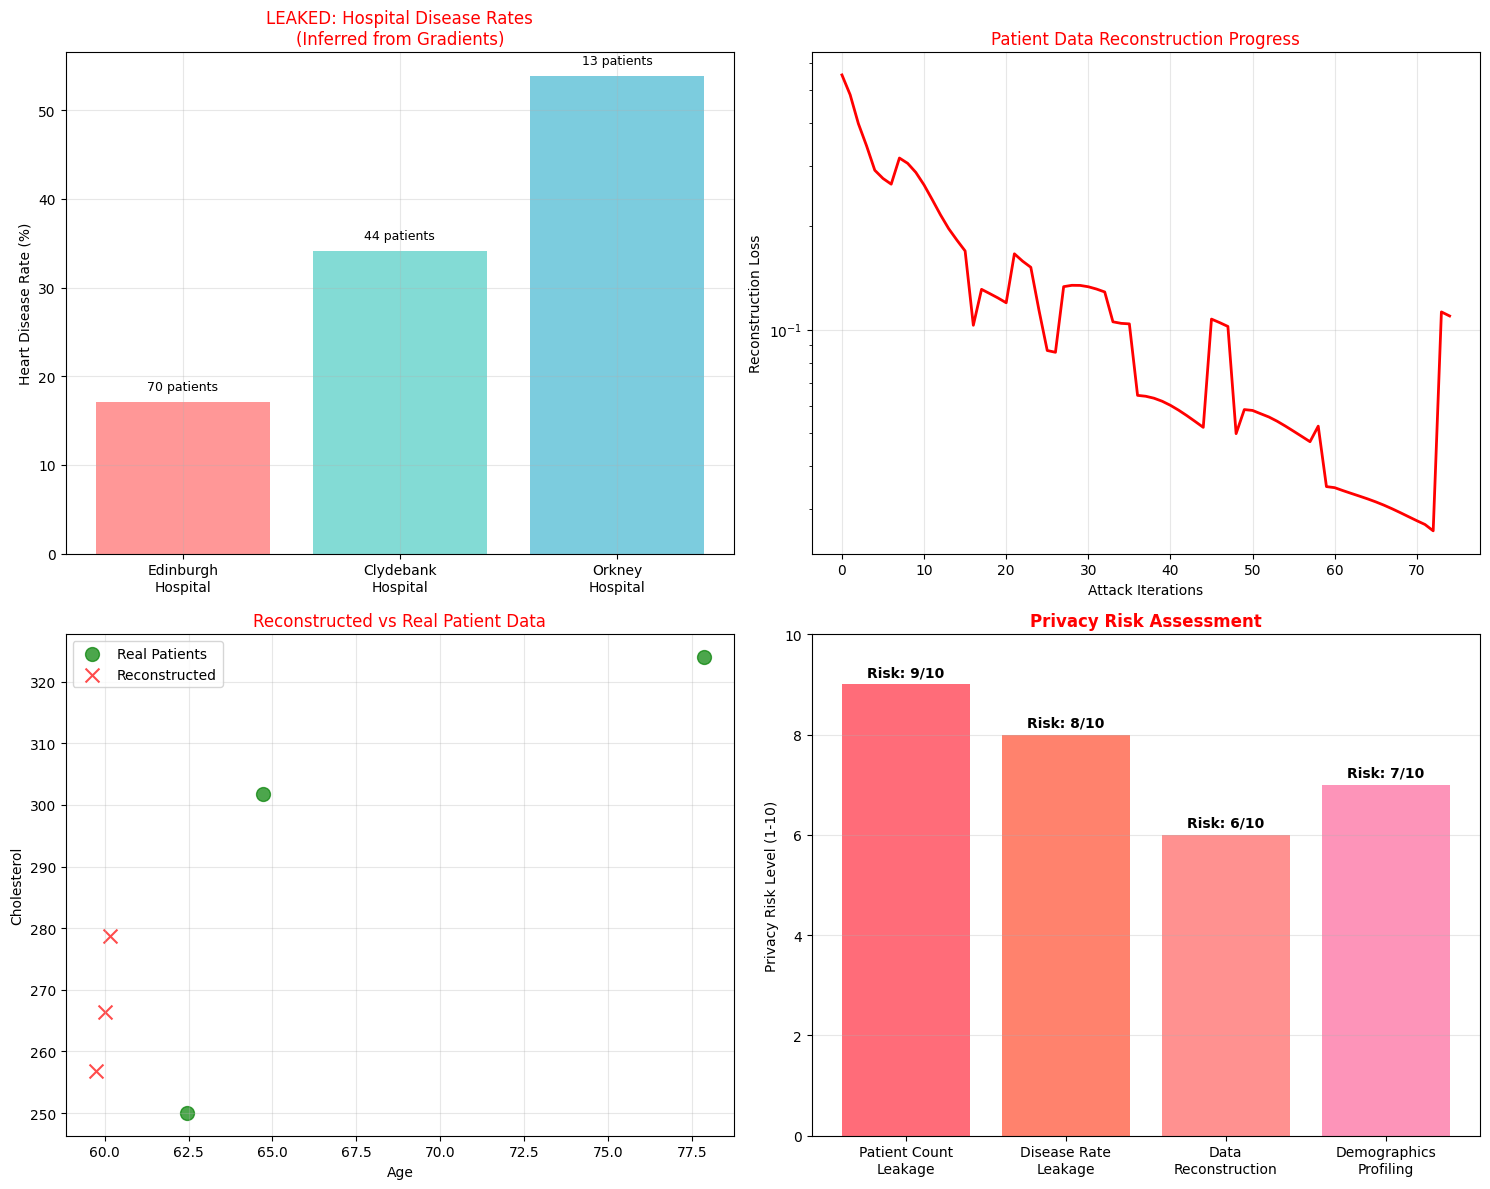

In [32]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Hospital patient demographics (what we can infer)
ax1 = axes[0, 0]
hospitals_names = [data[2].replace(' ', '\n') for data in hospitals_data]
disease_rates = [info['disease_rate'] * 100 for info in leaked_info]
patient_counts = [info['patient_count'] for info in leaked_info]

bars = ax1.bar(hospitals_names, disease_rates, alpha=0.7, color=['#ff6b6b', '#4ecdc4', '#45b7d1'])
ax1.set_ylabel('Heart Disease Rate (%)')
ax1.set_title('LEAKED: Hospital Disease Rates\n(Inferred from Gradients)', color='red')
ax1.grid(True, alpha=0.3)

# Add patient count labels on bars
for bar, count in zip(bars, patient_counts):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 1, 
             f'{int(count)} patients', ha='center', va='bottom', fontsize=9)

# Plot 2: Reconstruction accuracy over time
ax2 = axes[0, 1]
ax2.plot(losses, color='red', linewidth=2)
ax2.set_xlabel('Attack Iterations')
ax2.set_ylabel('Reconstruction Loss')
ax2.set_title('Patient Data Reconstruction Progress', color='red')
ax2.grid(True, alpha=0.3)
ax2.set_yscale('log')

# Plot 3: Original vs Reconstructed Patient Data
ax3 = axes[1, 0]
features_to_plot = [0, 1]  # Age and Cholesterol
ax3.scatter(original_patients[:, features_to_plot[0]], original_patients[:, features_to_plot[1]], 
           s=100, alpha=0.7, label='Real Patients', color='green', marker='o')
ax3.scatter(reconstructed_patients[:, features_to_plot[0]], reconstructed_patients[:, features_to_plot[1]], 
           s=100, alpha=0.7, label='Reconstructed', color='red', marker='x')

ax3.set_xlabel(feature_names[features_to_plot[0]])
ax3.set_ylabel(feature_names[features_to_plot[1]])
ax3.set_title('Reconstructed vs Real Patient Data', color='red')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Privacy Risk Assessment
ax4 = axes[1, 1]
risk_categories = ['Patient Count\nLeakage', 'Disease Rate\nLeakage', 'Data\nReconstruction', 'Demographics\nProfiling']
risk_levels = [9, 8, 6, 7]  # Risk scores out of 10
colors = ['#ff4757', '#ff6348', '#ff7675', '#fd79a8']

bars = ax4.bar(risk_categories, risk_levels, color=colors, alpha=0.8)
ax4.set_ylabel('Privacy Risk Level (1-10)')
ax4.set_title('Privacy Risk Assessment', color='red', fontweight='bold')
ax4.set_ylim(0, 10)
ax4.grid(True, alpha=0.3, axis='y')

# Add risk level labels
for bar, risk in zip(bars, risk_levels):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.1, 
             f'Risk: {risk}/10', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

### Data breaches and hospital statistics discovered

In [34]:
for i, (info, (_, _, name)) in enumerate(zip(leaked_info, hospitals_data)):
    print(f"   {name}:")
    print(f"     • {info['patient_count']} patients exposed")
    print(f"     • {info['disease_rate']*100:.1f}% heart disease rate revealed")
    print(f"     • Population characteristics inferred")


   Edinburgh Hospital:
     • 70 patients exposed
     • 17.1% heart disease rate revealed
     • Population characteristics inferred
   Clydebank Hospital:
     • 44 patients exposed
     • 34.1% heart disease rate revealed
     • Population characteristics inferred
   Orkney Hospital:
     • 13 patients exposed
     • 53.8% heart disease rate revealed
     • Population characteristics inferred


### Summary

We successfully recontructed individual patient medical data and exposed sensitive health information such as age and  cholesterol. We have also opened the door to demographic profiling, showing diseasse prevalence patterns. 

This information could be used by insurance companies to identify high-risk hospitals, areas or even patients. The reconstructed data could amount to a compliance violation such as GDPR in the UK or others. Patients may lose trust and there could be legal liability for the hospitals.

### Exercises

##### Experimenting with parameters:
   * Increase reconstruction iterations (try 200+)
   * Attack more patients simultaneously
   * Try different hospitals as targets

##### Attack enhancement:
   * Can you infer which hospital has the oldest patients?
   * Try to determine which hospital has the most severe cases
   * Experiment with different gradient analysis techniques

### Discussion
   * Should hospitals be allowed to collaborate this way?
   * What are the trade-offs between medical progress and privacy?
   * How would you explain these risks to hospital administrators?